# Warehouse Automation
Warehouse Automation Solution (using the frozen lake environment)
Source Code retrieved from: https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

In [37]:
!pip list 

Package              Version
-------------------- -------
asttokens            2.4.1
cloudpickle          3.0.0
colorama             0.4.6
comm                 0.2.2
contourpy            1.2.1
cycler               0.12.1
debugpy              1.8.1
decorator            5.1.1
exceptiongroup       1.2.0
executing            2.0.1
Farama-Notifications 0.0.4
fonttools            4.51.0
gym                  0.26.2
gym-notices          0.0.8
gymnasium            0.29.1
imageio              2.34.1
importlib_metadata   7.1.0
IProgress            0.4
ipykernel            6.29.3
ipython              8.24.0
ipywidgets           8.1.2
jedi                 0.19.1
jupyter_client       8.6.1
jupyter_core         5.7.2
jupyterlab_widgets   3.0.10
kiwisolver           1.4.5
matplotlib           3.9.0
matplotlib-inline    0.1.7
nest_asyncio         1.6.0
numpy                1.26.4
packaging            24.0
pandas               2.2.2
parso                0.8.4
pickleshare          0.7.5
pillow           

## Frozen Lake Source Code

This environment has been modified for the following:
- Introduced a new Tile type "C" for checkpoint
- Updated the reward function:
  - Original: 
    - Hole: 0
    - Frozen Tile: 0
    - Goal: 1
  - Updated:
    - Hole (Shelf): -100
    - Frozen Tile (Floor): -1
    - Checkpoint: 0
    - Goal: 10
- Added/Updated the images to simulate a warehouse

In [38]:
# Task 1: Update image folder location
# Replace the __file__ variable with the path to the "img" folder, excluding the "img" folder itself.
# E.G. __file__ = 'D:\User\Projects\Warehouse-Automation\\'

__file__ = 'D:\User\Projects\Warehouse-Automation\\'

<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Namsi\AppData\Local\Temp\ipykernel_19584\1863728111.py:5: SyntaxWarning: invalid escape sequence '\M'
  __file__ = 'D:\MMAI\MMAI845\Project\\'


In [39]:
## Source code for Frozen Lake Environment (https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py)
## Updated to support "checkpoints" between the final goal and the start

from contextlib import closing
from io import StringIO
from os import path
from typing import List, Optional

import numpy as np

from gym import Env, logger, spaces, utils
from gym.envs.toy_text.utils import categorical_sample
from gym.error import DependencyNotInstalled

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": ["SFFF", "FHFH", "FFIH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFIF",
        "FFFHFFFG",
    ],
}


# DFS to check that it's a valid path.
def is_valid(board: List[List[str]], max_size: int) -> bool:
    frontier, discovered = [], set()
    frontier.append((0, 0))
    while frontier:
        r, c = frontier.pop()
        if not (r, c) in discovered:
            discovered.add((r, c))
            directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
            for x, y in directions:
                r_new = r + x
                c_new = c + y
                if r_new < 0 or r_new >= max_size or c_new < 0 or c_new >= max_size:
                    continue
                if board[r_new][c_new] == "G": # Update this... we also want to check that all the checkpoints have been reached...
                    return True
                if board[r_new][c_new] != "H":
                    frontier.append((r_new, c_new))
    return False


def generate_random_map(size: int = 8, p: float = 0.8) -> List[str]:
    """Generates a random valid map (one that has a path from start to goal)

    Args:
        size: size of each side of the grid
        p: probability that a tile is frozen

    Returns:
        A random valid map
    """
    valid = False
    board = []  # initialize to make pyright happy

    while not valid:
        p = min(1, p)
        board = np.random.choice(["F", "H", "C"], (size, size), p=[p, 1 - p])
        board[0][0] = "S"
        board[-1][-1] = "G"
        valid = is_valid(board, size)
    return ["".join(x) for x in board]


class FrozenLakeEnv(Env):
    """
    Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H)
    by walking over the Frozen(F) lake. With new variable "C" for an intermediate checkpoint.
    The agent may not always move in the intended direction due to the slippery nature of the frozen lake.


    ### Action Space
    The agent takes a 1-element vector for actions.
    The action space is `(dir)`, where `dir` decides direction to move in which can be:

    - 0: LEFT
    - 1: DOWN
    - 2: RIGHT
    - 3: UP

    ### Observation Space
    The observation is a value representing the agent's current position as
    current_row * nrows + current_col (where both the row and col start at 0).
    For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
    The number of possible observations is dependent on the size of the map.
    For example, the 4x4 map has 16 possible observations.

    ### Rewards

    Reward schedule:
    - Reach goal(G): +10 
    - Reach hole(H): -100
    - Reach frozen(F): -1
    - Reach intermediate checkpoint(C): 0

    ### Arguments

    ```
    gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    ```

    `desc`: Used to specify custom map for frozen lake. For example,

        desc=["SFFF", "FHFH", "FFFH", "HFFG"].

        A random generated map can be specified by calling the function `generate_random_map`. For example,

        ```
        from gym.envs.toy_text.frozen_lake import generate_random_map

        gym.make('FrozenLake-v1', desc=generate_random_map(size=8))
        ```

    `map_name`: ID to use any of the preloaded maps.

        "4x4":[
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
            ]

        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG",
        ]

    `is_slippery`: True/False. If True will move in intended direction with
    probability of 1/3 else will move in either perpendicular direction with
    equal probability of 1/3 in both directions.

        For example, if action is left and is_slippery is True, then:
        - P(move left)=1/3
        - P(move up)=1/3
        - P(move down)=1/3

    ### Version History
    * v1: Bug fixes to rewards
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        desc=None,
        map_name="4x4",
        is_slippery=True,
    ):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        self.initial_state_distrib = np.array(desc == b"S").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()

        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            terminated = bytes(newletter) in b"GH"
            reward = float(get_reward(newletter))
            return newstate, reward, terminated
        
        def get_reward(b):
            if b == b"H":
                return -100
            elif b == b"G":
                return 0
            elif b == b"C":
                return -1
            return -3

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = self.P[s][a]
                    letter = desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append(
                                    (1.0 / 3.0, *update_probability_matrix(row, col, b))
                                )
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        self.observation_space = spaces.Discrete(nS)
        self.action_space = spaces.Discrete(nA)

        self.render_mode = render_mode

        # pygame utils
        self.window_size = (min(64 * ncol, 512), min(64 * nrow, 512))
        self.cell_size = (
            self.window_size[0] // self.ncol,
            self.window_size[1] // self.nrow,
        )
        self.window_surface = None
        self.clock = None

        # Updated images
        self.shelf_img = None
        self.broken_shelf_img = None
        self.floor_img = None
        self.robot_images = None
        self.goal_img = None
        self.start_img = None
        self.package_img = None

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1}

    def render(self):
        if self.render_mode is None:
            logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
        elif self.render_mode == "ansi":
            return self._render_text()
        else:  # self.render_mode in {"human", "rgb_array"}:
            return self._render_gui(self.render_mode)

    def _render_gui(self, mode):
        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        if self.window_surface is None:
            pygame.init()

            if mode == "human":
                pygame.display.init()
                pygame.display.set_caption("Frozen Lake")
                self.window_surface = pygame.display.set_mode(self.window_size)
            elif mode == "rgb_array":
                self.window_surface = pygame.Surface(self.window_size)

        assert (
            self.window_surface is not None
        ), "Something went wrong with pygame. This should never happen."

        
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.shelf_img is None:
            file_name = path.join(path.dirname(__file__), "img\\shelf.png")
            self.shelf_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.broken_shelf_img is None:
            file_name = path.join(path.dirname(__file__), "img\\broken_shelf.png")
            self.broken_shelf_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.floor_img is None:
            file_name = path.join(path.dirname(__file__), "img\\floor.png")
            self.floor_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.goal_img is None:
            file_name = path.join(path.dirname(__file__), "img\\goal.png")
            self.goal_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.package_img is None:
            file_name = path.join(path.dirname(__file__), "img\\box.png")
            self.package_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.start_img is None:
            file_name = path.join(path.dirname(__file__), "img\\stool.png")
            self.start_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.robot_images is None:
            robots = [
                path.join(path.dirname(__file__), "img\\robot_left.png"),
                path.join(path.dirname(__file__), "img\\robot_down.png"),
                path.join(path.dirname(__file__), "img\\robot_right.png"),
                path.join(path.dirname(__file__), "img\\robot_up.png"),
            ]
            self.robot_images = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in robots
            ]

        desc = self.desc.tolist()
        assert isinstance(desc, list), f"desc should be a list or an array, got {desc}"
        for y in range(self.nrow):
            for x in range(self.ncol):
                pos = (x * self.cell_size[0], y * self.cell_size[1])
                rect = (*pos, *self.cell_size)

                self.window_surface.blit(self.floor_img, pos)
                if desc[y][x] == b"H":
                    self.window_surface.blit(self.shelf_img, pos)
                elif desc[y][x] == b"G":
                    self.window_surface.blit(self.goal_img, pos)
                elif desc[y][x] == b"S":
                    self.window_surface.blit(self.start_img, pos)
                elif desc[y][x] == b"C":
                    self.window_surface.blit(self.package_img, pos)

                pygame.draw.rect(self.window_surface, (180, 200, 230), rect, 1)

        # paint the elf
        bot_row, bot_col = self.s // self.ncol, self.s % self.ncol
        cell_rect = (bot_col * self.cell_size[0], bot_row * self.cell_size[1])
        last_action = self.lastaction if self.lastaction is not None else 1
        robot_img = self.robot_images[last_action]

        if desc[bot_row][bot_col] == b"H":
            self.window_surface.blit(self.broken_shelf_img, cell_rect)
        else:
            self.window_surface.blit(robot_img, cell_rect)

        if mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

    @staticmethod
    def _center_small_rect(big_rect, small_dims):
        offset_w = (big_rect[2] - small_dims[0]) / 2
        offset_h = (big_rect[3] - small_dims[1]) / 2
        return (
            big_rect[0] + offset_w,
            big_rect[1] + offset_h,
        )

    def _render_text(self):
        desc = self.desc.tolist()
        outfile = StringIO()

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n")
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window_surface is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()


# Elf and stool from https://franuka.itch.io/rpg-snow-tileset
# All other assets by Mel Tillery http://www.cyaneus.com/

## Reinforcement Learning

Section 1: Q Learning

Section 2: SARSA

In [40]:
# Import Dependencies

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

### Q Learning Implementation

In [41]:
from pathlib import Path
from typing import NamedTuple

# Set top level constants
sns.set_theme()
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

# Class for the hyperparameters (and commonly referenced variables)
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discount rate
    epsilon: float  # Exploration probability
    map_size: int  # Length of the map
    seed: int  # Random seed
    is_slippery: bool  # True for stochastic environment, false for deterministic
    n_runs: int  # Number of runs
    action_size: int  # Action space size
    state_size: int  # Observation space size
    proba_frozen: float  # Probability that a tile is a floor tile (1-proba_frozen = probability for a shelf)
    savefig_folder: Path  # Where to save the final figure/images

# Set the hyperparameters

# Task 2: Update the hyperparameters
params = Params(
    total_episodes=1001,
    learning_rate=0.6,
    gamma=0.99,
    epsilon=0.07,
    map_size=121,
    seed=42,
    is_slippery=False,
    n_runs=1,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("output"),
)

rng = np.random.default_rng(params.seed)
params.savefig_folder.mkdir(parents=True, exist_ok=True)
print("Parameters: ", params)

Parameters:  Params(total_episodes=1001, learning_rate=0.6, gamma=0.99, epsilon=0.07, map_size=121, seed=42, is_slippery=False, n_runs=1, action_size=None, state_size=None, proba_frozen=0.9, savefig_folder=WindowsPath('output'))


In [42]:
env = FrozenLakeEnv()
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print("Action size: ", params.action_size)
print("State size: ",params.state_size)

Action size:  4
State size:  16


In [43]:
# Define our Q-learning agent/class (Tabular)
class Qlearning:
    # Initialize the Q-table
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    # Update the Q-table based on the Bellman equation
    # Q(s,a) = Q(s, a) + alpha * (r(s,a) + gamma * Q(s',a') - Q(s,a))
    def update(self, state, action, reward, new_state):
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    # Reset the Q-table
    def reset_qtable(self):
        self.qtable = np.zeros((self.state_size, self.action_size))


# Define the Epsilon Greedy policy
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    # Choose an action based on the epsilon greedy policy, exclu
    def choose_action(self, action_space, state, qtable):
        explore_exploit_tradeoff = rng.uniform(0, 1)

        # If the random number is less than epsilon, we explore
        if explore_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Otherwise, we exploit
        else:
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action
    

# Initialize the Q-learning agent and the explorer
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)

explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [44]:
# The code for running the environment and training the agent

def run_env():
    # Initialize all the variables to 0 or empty
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    # Loop through the number of runs
    for run in range(params.n_runs):

        # Reset the Q-table between runs
        learner.reset_qtable()

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            # Reset the environment at the start of each episode
            state = env.reset(seed=params.seed)[0] 
            step = 0
            done = False
            total_rewards = 0

            # Loop through the episode, until the agent reaches the goal.
            while not done:

                # Comment the following section in, if you want to print a frame by frame of the final run
                # if episode == len(episodes) - 1:
                #     fig, ax = plt.subplots(figsize=(15, 5))

                #     # Display the image in the subplot
                #     ax.imshow(env.render())
                #     ax.axis("off")
                #     ax.set_title("Step Number: " + str(step))

                #     img_title = f"QLEARN_frozen_lake_final_run__step{str(step)}.png"
                #     fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
                #     plt.show()

                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [45]:
# Helper/Utitlity functions

# Convert the results of the simulation in dataframes
def postprocess(episodes, params, rewards, steps, map_size):
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

# Use the Q-table to get the best learned action. And return the policy
def qtable_directions_map(qtable, map_size):
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    # print(qtable_best_action)
    # print(qtable_val_max)
    # print(len(qtable_val_max))
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    for idx, val in enumerate(qtable_best_action.flatten()):
        if val != 0:
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

# Plot the Policy Learned and the Final Result of the Simulation
def plot_q_values_map(qtable, env, map_size):
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the final frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        # annot=True,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[]
        # annot_kws={"fontsize": "xx-large"},vmin=-100,vmax=100
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"warehouse_automation_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

# Plot the state-actions
def plot_states_actions_distribution(states, actions, map_size, learningType):
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title(f"States ({learningType})")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title(f"Actions ({learningType})")
    fig.tight_layout()
    img_title = f"warehouse_automation_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()    
    

Map size: 8x8


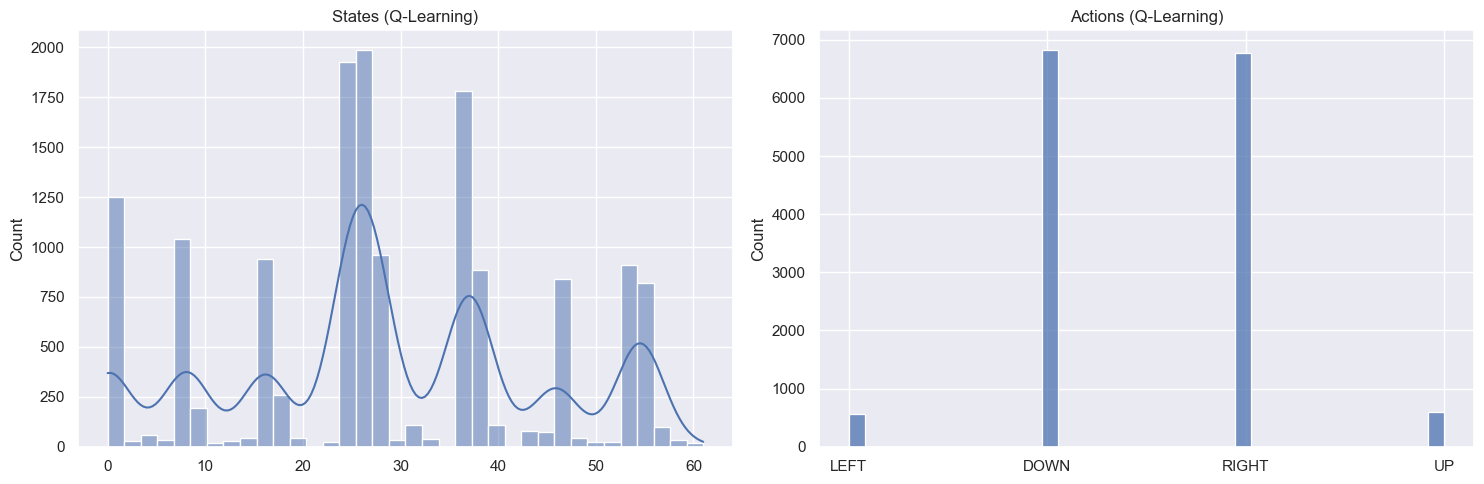

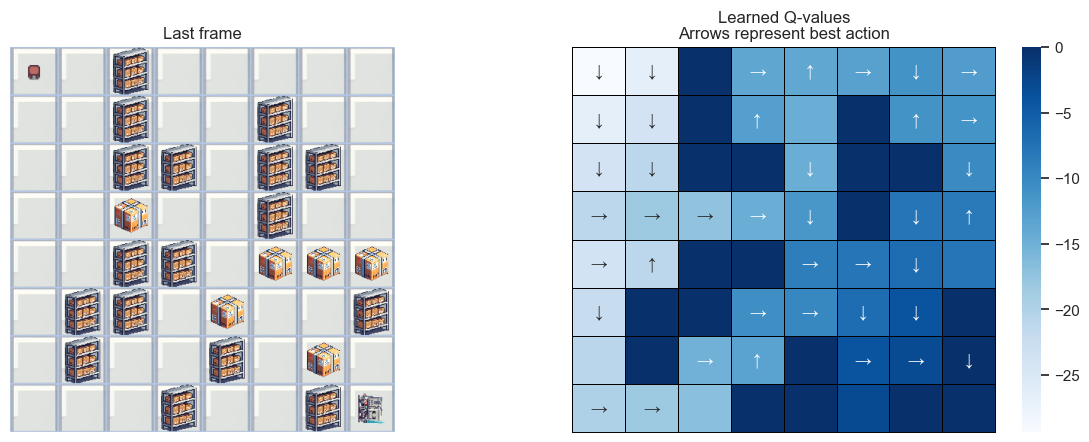

In [46]:
# Task 4: (optional) Update the custom map:

# We can run this code in one of two ways:
# 1. Generate a random map (this will not include any checkpoints)
# 2. Use a custom map (This allows checkpoints)
# Comment in/out the option you don't want to use. Currently, we are using option 2.

# Option 1: Generate a random map
# Pass in the size of the map (e.g. 4, 8, 12, 16, etc.).
# We can pass more than 1 size (e.g. [4, 8, 12, 16]). This will run a different simulation for each map size.
#
# map_sizes = [25]


# Option 2: Use a custom map
# Pass in the custom map as a list of strings. The map should be a square.
# Each string represents a row in the map.
# S = Start, F = Frozen, H = Hole, C = Checkpoint, G = Goal
# Also pass in the size of the map. 
#

custom_map = [
    "SFHFFFFF",
    "FFHFFHFF",
    "FFHHFHHF",
    "FFCFFHFF",
    "FFHHFCCC",
    "FHHFCFFH",
    "FHFFHFCF",
    "FFFHFFHG",
]

# custom_map = [
#     "SFFFFFCFFFFFH",
#     "FFCHHFFFFHHFH",
#     "FCFHHHFFHHFFF",
#     "FFFHHHFHHFFHF",
#     "FFHHHHFHFFFFH",
#     "FHFFFFFFFHFFF",
#     "FFFFFHFFFHHFF",
#     "HHHHHFFFFFHHH",
#     "FFFFCFHFFHHFF",
#     "FFFHCFFFFFHHF",
#     "FFHFCFFHFFFFF",
#     "FHHCCCHHFFHHF",
#     "FFHFFFFFFFFHG",
# ]

# custom_map = [
#     "SFHFFCCFFFFFH",
#     "FFCHFFFFFCHFH",
#     "FFCHFFHHFHHFH",
#     "FFCHFFHHFHHFH",
#     "FFCHFFHHFHHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFFFFFHHFCHFF",
#     "FFFFFFHHFFFFG",
# ]


# custom_map = [
#     "SFHFFFFFFFFHFFFFFFFHHHFFF",
#     "FFHFFHFFFFFFHFFHHFFFFFFFH",
#     "FFHHFHHFFFFHHFFFFHHFFFFHH",
#     "FFCFFHFFFFFCFFFHFFFFHFFFC",
#     "FFHHFCCCCCCCFFHHFFCCCCFFF",
#     "FHHFCFFHFFFFHFFCFFHFFHFFH",
#     "FHFFHFCFFFFFFHFFHFFCFFFFF",
#     "FFFHFFHCFFFFHFFHHFFFCCCFF",
#     "FFHFFFFFFFHHFFHFFFFFHHHFF",
#     "FFHHFFFFFHFFFFFFHHFFFHFFF",
#     "FFFCCFFFHFFFFFCCCCCCFFFFF",
#     "HHHHFFFHHFFHHFFFFHFFFHFFF",
#     "FFHHFFFHFFFHFFFFFFHFFFFFF",
#     "FFFFFFCFFFFHFFCCCHFFHFFFC",
#     "FHHHFFFFFFCFFFFHHHFFFFHHF",
#     "FFFHFFFCCFFFFHFFFCCCCFFCC",
#     "FFHFFFHFFFFHFFHHFFFHFFHFF",
#     "HHFFFHFFFCFHHFFFHFFFFHFFF",
#     "FFFFHFFHHFFFFCCFFFHHFFHHF",
#     "CCFFHFFHFFFFFFHFFFHHCCFFF",
#     "FFHFFFFHHFFFFFFFHHHFFFFFH",
#     "FFFHFFHFFFFFFHFFHFFFFFFFH",
#     "FHHFFHFFFFHFFFFHHFFFFHHFF",
#     "FFFFHFFFHFFFFFHHHFFFHFFFF",
#     "FFFHFFHFFFFFFHFFFHFFFFFFG"
# ]


# custom_map = [
#     "SFFF",
#     "FHCH",
#     "FFFH",
#     "HFCG"
# ]


# params._replace(total_episodes=800)
# params._replace(epsilon=0.08)
# params._replace(learning_rate=0.7)
# params._replace(gamma=0.99)
# params._replace(n_runs=1)
# params._replace(proba_frozen=0.9)
# params._replace(is_slippery=False)

map_sizes = [len(custom_map)]


res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = FrozenLakeEnv(
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        # Option 1: Generate a random map
        # desc=generate_random_map(
        #     size=map_size, p=params.proba_frozen, seed=params.seed
        # ),
        #
        # Option 2: Use a custom map
        desc=custom_map
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    ) 
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size, learningType='Q-Learning'
    )
    plot_q_values_map(qtable, env, map_size)

    env.close()

C:\Users\Namsi\AppData\Local\Temp\ipykernel_19584\1793133253.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


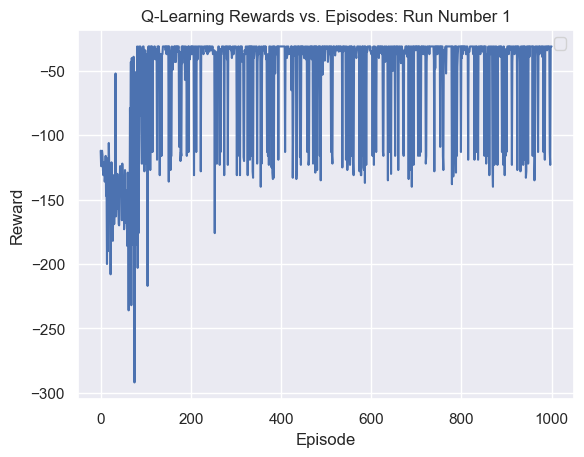

In [47]:
# Plot the rewards and Episodes
def plot_rew(title, rew_list):
    plt.ioff()
    plt.title("Q-Learning Rewards vs. Episodes: {}".format(title))
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(rew_list)
    plt.legend()
    plt.show()

for i in range(len(rewards[0])):
    plot_rew(f'Run Number {i+1}', rewards[:, i])

In [48]:
actions = ["left", "down", "right", "up"]
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)

# Display the Q-table after training
df = pd.DataFrame(qtable, columns=actions)
display(df)

,left,down,right,up
0,-32.065707,-29.359301,-29.359301,-32.065708
1,-30.086198,-26.625556,-84.000000,-27.539590
2,0.000000,0.000000,0.000000,0.000000
3,-60.000000,-14.325006,-13.538641,-14.101202
4,-14.034980,-14.159393,-14.346485,-13.650924
...,...,...,...,...
59,0.000000,0.000000,0.000000,0.000000
60,0.000000,-2.520000,-4.444560,-84.000000
61,-2.923200,-4.304880,-97.440000,-4.987143
62,0.000000,0.000000,0.000000,0.000000


### SARSA Implementation

In [49]:
# Define the SARSA agent/class (Tabular)
class SARSA:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    # Update Q(s,a) = Q(s_a) + alpha * (r(s,a) + gamma * Q(s',a') - Q(s,a))
    def update(self, state, action, reward, new_state, new_action):
        delta = reward + self.gamma * self.qtable[new_state, new_action] - self.qtable[state, action]
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    # Reset the Q-table
    def reset_qtable(self):
        self.qtable = np.zeros((self.state_size, self.action_size))

# Run the SARSA algorithm
def run_env_sarsa():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            # Choose the initial action
            action = explorer.choose_action(
                action_space=env.action_space, state=state, qtable=learner.qtable
            )

            while not done:
                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)
                
                # Uncomment the following section if you want to print a frame by frame of the final run
                # if episode == len(episodes) - 1:
                #         # Create a single subplot
                #         fig, ax = plt.subplots(figsize=(15, 5))

                #         # Display the image in the subplot
                #         ax.imshow(env.render())
                #         ax.axis("off")
                #         ax.set_title("Step Number: " + str(step))

                #         img_title = f"SARSA_frozen_lake_final_run__step{str(step)}.png"
                #         fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
                #         plt.show()

                # Choose the next action based on the new state
                new_action = explorer.choose_action(
                    action_space=env.action_space, state=new_state, qtable=learner.qtable
                )

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state, new_action
                )

                total_rewards += reward
                step += 1

                # Our new state is state, new action is the action
                state = new_state
                action = new_action

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions


# Helper functions (similar to Q-learning but now for SARSA)
# Convert the results of the simulation in dataframes
def postprocess_sarsa(episodes, params, rewards, steps, map_size):
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

# Plot the Policy Learned and the Final Result of the Simulation
def plot_q_values_map_sarsa(qtable, env, map_size):
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)
    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[]
    ).set(title="Learned SARSA\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

    fig, ax = plt.subplots(figsize=(15, 5))




Map size: 8x8


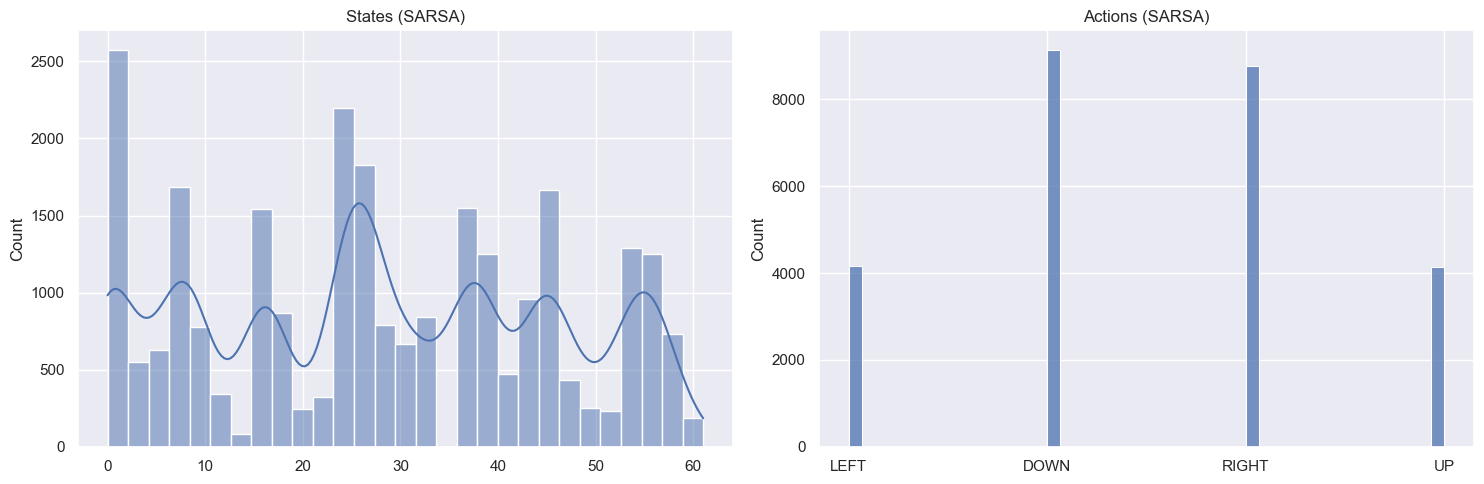

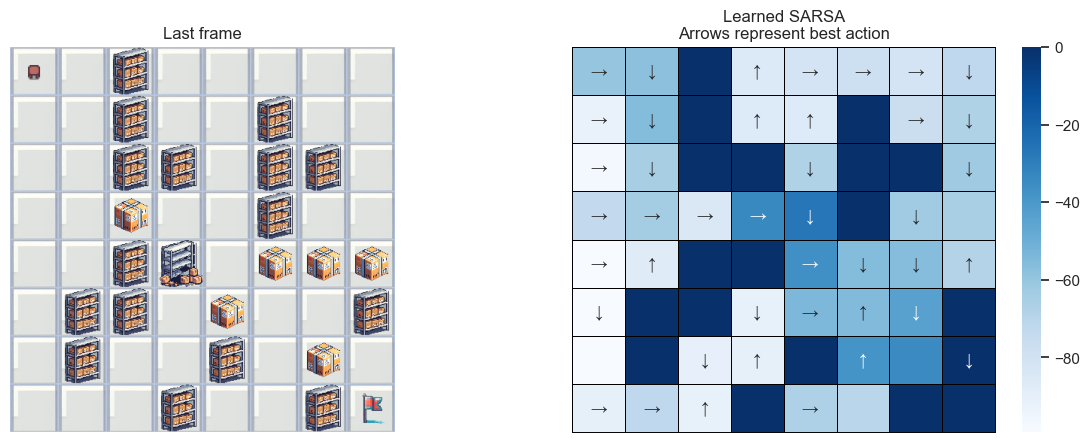

In [50]:
# Task 5: (optional) Update the custom map:
# Same steps as Task 4

# We can run this code in one of two ways:
# 1. Generate a random map (this will not include any checkpoints)
# 2. Use a custom map (This allows checkpoints)
# Comment in/out the option you don't want to use. Currently, we are using option 2.

# Option 1: Generate a random map
# Pass in the size of the map (e.g. 4, 8, 12, 16, etc.).
# We can pass more than 1 size (e.g. [4, 8, 12, 16]). This will run a different simulation for each map size.
#
# map_sizes = [25]


# Option 2: Use a custom map
# Pass in the custom map as a list of strings. The map should be a square.
# Each string represents a row in the map.
# S = Start, F = Frozen, H = Hole, C = Checkpoint, G = Goal
# Also pass in the size of the map. 
#

custom_map = [
    "SFHFFFFF",
    "FFHFFHFF",
    "FFHHFHHF",
    "FFCFFHFF",
    "FFHHFCCC",
    "FHHFCFFH",
    "FHFFHFCF",
    "FFFHFFHG",
]

# custom_map = [
#     "SFFFFFCFFFFFH",
#     "FFCHHFFFFHHFH",
#     "FCFHHHFFHHFFF",
#     "FFFHHHFHHFFHF",
#     "FFHHHHFHFFFFH",
#     "FHFFFFFFFHFFF",
#     "FFFFFHFFFHHFF",
#     "HHHHHFFFFFHHH",
#     "FFFFCFHFFHHFF",
#     "FFFHCFFFFFHHF",
#     "FFHFCFFHFFFFF",
#     "FHHCCCHHFFHHF",
#     "FFHFFFFFFFFHG",
# ]

# custom_map = [
#     "SFHFFCCFFFFFH",
#     "FFCHFFFFFCHFH",
#     "FFCHFFHHFHHFH",
#     "FFCHFFHHFHHFH",
#     "FFCHFFHHFHHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFCHFFHHFCHFH",
#     "FFFFFFHHFCHFF",
#     "FFFFFFHHFFFFG",
# ]


# custom_map = [
#     "SFHFFFFFFFFHFFFFFFFHHHFFF",
#     "FFHFFHFFFFFFHFFHHFFFFFFFH",
#     "FFHHFHHFFFFHHFFFFHHFFFFHH",
#     "FFCFFHFFFFFCFFFHFFFFHFFFC",
#     "FFHHFCCCCCCCFFHHFFCCCCFFF",
#     "FHHFCFFHFFFFHFFCFFHFFHFFH",
#     "FHFFHFCFFFFFFHFFHFFCFFFFF",
#     "FFFHFFHCFFFFHFFHHFFFCCCFF",
#     "FFHFFFFFFFHHFFHFFFFFHHHFF",
#     "FFHHFFFFFHFFFFFFHHFFFHFFF",
#     "FFFCCFFFHFFFFFCCCCCCFFFFF",
#     "HHHHFFFHHFFHHFFFFHFFFHFFF",
#     "FFHHFFFHFFFHFFFFFFHFFFFFF",
#     "FFFFFFCFFFFHFFCCCHFFHFFFC",
#     "FHHHFFFFFFCFFFFHHHFFFFHHF",
#     "FFFHFFFCCFFFFHFFFCCCCFFCC",
#     "FFHFFFHFFFFHFFHHFFFHFFHFF",
#     "HHFFFHFFFCFHHFFFHFFFFHFFF",
#     "FFFFHFFHHFFFFCCFFFHHFFHHF",
#     "CCFFHFFHFFFFFFHFFFHHCCFFF",
#     "FFHFFFFHHFFFFFFFHHHFFFFFH",
#     "FFFHFFHFFFFFFHFFHFFFFFFFH",
#     "FHHFFHFFFFHFFFFHHFFFFHHFF",
#     "FFFFHFFFHFFFFFHHHFFFHFFFF",
#     "FFFHFFHFFFFFFHFFFHFFFFFFG"
# ]


# custom_map = [
#     "SFFF",
#     "FHCH",
#     "FFFH",
#     "HFCG"
# ]

map_sizes = [len(custom_map)]

# params._replace(total_episodes=800)
# params._replace(epsilon=0.08)
# params._replace(learning_rate=0.7)
# params._replace(gamma=0.99)
# params._replace(n_runs=1)
# params._replace(proba_frozen=0.9)
# params._replace(is_slippery=False)

res_all = pd.DataFrame()
st_all = pd.DataFrame()


for map_size in map_sizes:
    env = FrozenLakeEnv(
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        # Option 1: Generate a random map
        # desc=generate_random_map(
        #     size=map_size, p=params.proba_frozen, seed=params.seed
        # ),
        #
        # Option 2: Use a custom map
        desc=custom_map
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = SARSA(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards_sarsa, steps_sarsa, episodes_sarsa, qtables_sarsa, all_states_sarsa, all_actions_sarsa = run_env_sarsa()

    # Save the results in dataframes
    res_sarsa, st_sarsa = postprocess_sarsa(episodes_sarsa, params, rewards_sarsa, steps_sarsa, map_size)
    res_all_sarsa = pd.concat([res_all, res_sarsa])
    st_all_sarsa = pd.concat([st_all, st_sarsa])
    qtable_sarsa = qtables_sarsa.mean(axis=0)
    plot_states_actions_distribution(
        states=all_states_sarsa, actions=all_actions_sarsa, map_size=map_size, learningType='SARSA'
    )
    plot_q_values_map_sarsa(qtable_sarsa, env, map_size)

    env.close()

C:\Users\Namsi\AppData\Local\Temp\ipykernel_19584\3294341227.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


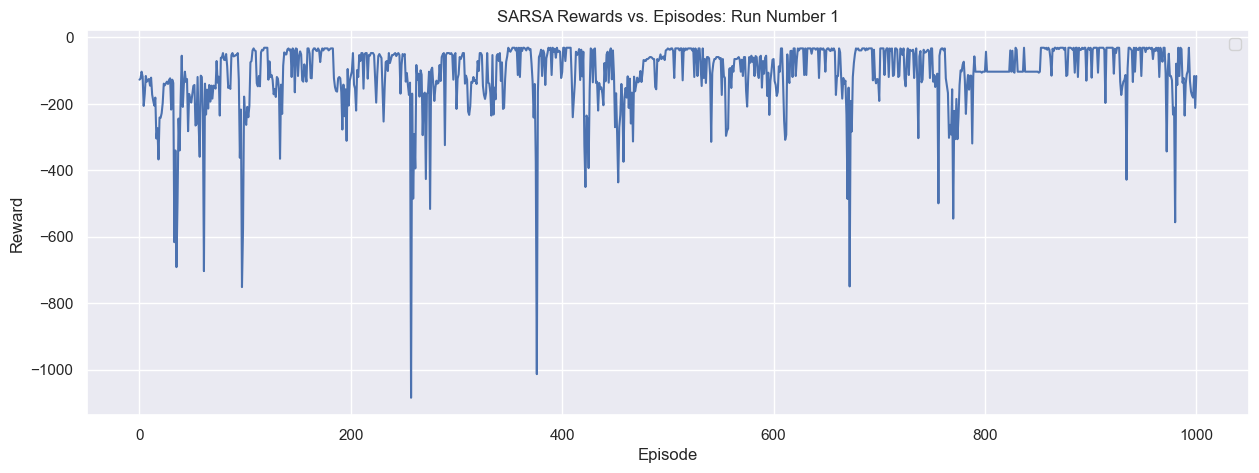

In [51]:
# Plot the rewards and Episodes
def plot_rew(title, rew_list):
    plt.ioff()
    plt.title("SARSA Rewards vs. Episodes: {}".format(title))
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(rew_list)
    plt.legend()
    plt.show()

for i in range(len(rewards_sarsa[0])):
    plot_rew(f'Run Number {i+1}', rewards_sarsa[:, i])

In [52]:
actions = ["left", "down", "right", "up"]
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)

# Display the Q-table after training
df = pd.DataFrame(qtable_sarsa, columns=actions)
display(df)

,left,down,right,up
0,-100.470821,-99.647880,-60.080410,-77.532312
1,-99.576781,-57.544230,-100.000000,-87.400620
2,0.000000,0.000000,0.000000,0.000000
3,-93.600000,-86.051719,-87.042016,-85.551330
4,-86.655127,-88.291533,-81.657896,-86.964972
...,...,...,...,...
59,0.000000,0.000000,0.000000,0.000000
60,-84.000000,-69.297596,-67.356812,-84.000000
61,-70.403697,-70.423193,-97.440000,-72.140010
62,0.000000,0.000000,0.000000,0.000000
